In [ ]:
# SPARK INSTALLATION

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark

--2020-07-09 07:08:26--  https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220272364 (210M) [application/x-gzip]
Saving to: ‘spark-3.0.0-bin-hadoop2.7.tgz’

spark-3.0.0-bin-had 100%[===================>] 210.07M  20.0MB/s    in 12s     

2020-07-09 07:08:38 (18.2 MB/s) - ‘spark-3.0.0-bin-hadoop2.7.tgz’ saved [220272364/220272364]



In [ ]:
# INIT STUFF OF ANY SPARK CODE

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

import findspark
findspark.init()

import pyspark 
conf = pyspark.SparkConf().setMaster('local[4]').setAppName('my first Spark')
sc = pyspark.SparkContext( conf=conf )

# OTHER STUFF
import numpy as np
import pandas as pd
import pickle

# DRIVE CONNECTION
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/SDA")

# SKLEARN
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

# MATPLOTLIB
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# PLOT FUNCTION

def result_plot(X, Y_test, Y_pred):
  plt.figure()
  
  plt.scatter(X, Y_test, marker='^', color='red', label='Real labels')
  plt.scatter(X, Y_pred, color='navy', label='Estimate')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
# DATASET IMPORT (CERVICAL CANCER)

dataset = pd.read_csv("cervical_cancer.csv", na_values='?')
filter = [c for c in dataset.columns if c != 'STDs: Time since first diagnosis' and c != 'STDs: Time since last diagnosis']
dataset = dataset[filter].dropna()
columns = [c for c in dataset.columns if c != "Biopsy"]

X_train, X_test, y_train, y_test = train_test_split(dataset[columns], dataset["Biopsy"], test_size=0.2, random_state=42)
D_train = np.column_stack((X_train, y_train))
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
# DATASET IMPORT (BREAST CANCER)

dataset = pd.read_csv("breast_cancer.csv")
filter = [c for c in dataset.columns if c != 'id' and c!= "Unnamed: 32"]
dataset = dataset[filter].dropna()
dataset = pd.get_dummies(dataset)
filter = [c for c in dataset.columns if c != "diagnosis_M"]
dataset = dataset[filter]
columns = [c for c in dataset.columns if c != "diagnosis_B"]
X = dataset[columns]
y = dataset['diagnosis_B']

In [ ]:
# CORRELATION FILTER < 0.6
columns = ['radius_mean','smoothness_mean','symmetry_mean','fractal_dimension_mean', 'texture_se', 'smoothness_se', 'compactness_se','symmetry_se', 'texture_worst']
X = X[columns]

In [ ]:
# CORRELATION FILTER < 0.3
columns = ['radius_mean','smoothness_mean', 'texture_se', 'fractal_dimension_se']
X = X[columns]

In [ ]:
# PCA

scaler = StandardScaler()
pca = PCA()
X_pca = pca.fit_transform(scaler.fit_transform(X))
X = X_pca[:, 0]

In [ ]:
# PCA PLOT
PVE = pca.explained_variance_ratio_

plt.figure(figsize=(10,10))
plt.plot(PVE, 'b-', marker='o')
#plt.yticks(np.linspace(0.4,1,7))
plt.ylabel('PVE')
plt.xlabel('Component')
plt.title("PVE")
plt.savefig('PVE.png')
#plt.legend(loc='best')
plt.show()

pca.components_[0]


In [ ]:
# TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
D_train = np.column_stack((X_train, y_train))
if type(X_test) != np.ndarray:
  X_test = X_test.to_numpy()

RDD = sc.parallelize(D_train).cache()

In [ ]:
# MAJORITY VOTING FUNCTION

def majority_voting(values):
  counter = dict()
  for n in values:
    d_k = int(n[-1])
    if d_k in counter:
      counter[d_k] += 1
    else:
      counter[d_k] = 1
  return max(counter.keys(), key=lambda k: counter[k])

In [ ]:
# K-NN PARALLEL IMPLEMENTATION

def euclidean_distance(element):
  return ((element[:-1]-x_br.value)**2).sum()

def k_nearest(data):
  return sorted(data, key=euclidean_distance)[:k_br.value]

y_pred_knn = [0, 1]
k = 1
knn_predictions = dict()
while sum(y_pred_knn) != 0 and sum(y_pred_knn) != len(y_pred_knn):
  print(k)
  k_br = sc.broadcast(k)
  y_pred_knn = []
  for x in X_test:
    x_br = sc.broadcast(x)
    nn = k_nearest(RDD.mapPartitions(k_nearest).collect())
    y_pred_knn.append(majority_voting(nn))
  knn_predictions[k] = y_pred_knn
  k += 20
  pickle.dump(knn_predictions, open("knn_results_c06.roc", "wb"))


In [ ]:
# LOGISTIC REGRESSION WITH SGD

def sigmoid(x_i, weights):
  y_hat = np.matmul(weights, x_i.T)
  return 1/(1+np.exp(-y_hat))

def nabla(v): 
  x = np.insert(v[:-1], 0, 1)                     
  y = -1+2*v[-1]
  w_dot_x = np.matmul(w_br.value,x.T)             
  return -y*(1 - 1/(1+np.exp(-y*w_dot_x)))*x

def add_nabla(a, b):
  return a+b

#iterations = [1, 10, 50, 100, 500, 1000, 2000, 3000, 5000, 10000]
# learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
iterations = [10]
learning_rates = [0.5]
lr_predictions = dict()
for lr in learning_rates:
  for it in iterations:
    print(it)
    w = np.zeros(shape=(D_train.shape[1],))
    w_br = sc.broadcast(w)
    for i in range(it):
      gradient = RDD.map(nabla).reduce(add_nabla)
      w = w - lr * gradient//D_train[0]
      w_br = sc.broadcast(w)

    y_pred_lrd, y_pred_lrp = [], []
    for x in X_test:
      x_offset = np.insert(np.array(x), 0, 1)
      y_i = sigmoid(x_offset, w)
      y_pred_lrp.append(y_i)
      y_pred_lrd.append(1 if y_i > 0.5 else 0)
    lr_predictions[it] = y_pred_lrd
    #pickle.dump(lr_predictions, open("lr_results_c03.roc", "wb"))

In [ ]:
# ERROR FUNCTION PLOT

def logistic_loss(w, x, y):
  x = np.insert(x, 0, 1)                 
  y = -1+2*y
  w_dot_x = np.matmul(w.T,x)
  ret = np.log(1 + np.exp(-y*w_dot_x))  
  #ret = 1 + np.exp(-y*w_dot_x)
  return ret

x_e = np.linspace(-200, 100, 200)
y_e = np.linspace(100, -100, 200)
z = np.zeros((200,200))

for x_i, w_x in enumerate(x_e):
  for y_i, w_y in enumerate(y_e):
    # print(x_i, y_i)
    w_tmp = np.array([w_x, w_y])
    loss_values = []
    for x_t in D_train:
      loss_values.append(logistic_loss(w_tmp, x_t[0:-1], x_t[1]))
    z[x_i, y_i] = sum(loss_values)/len(loss_values)

print("OK")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


OK


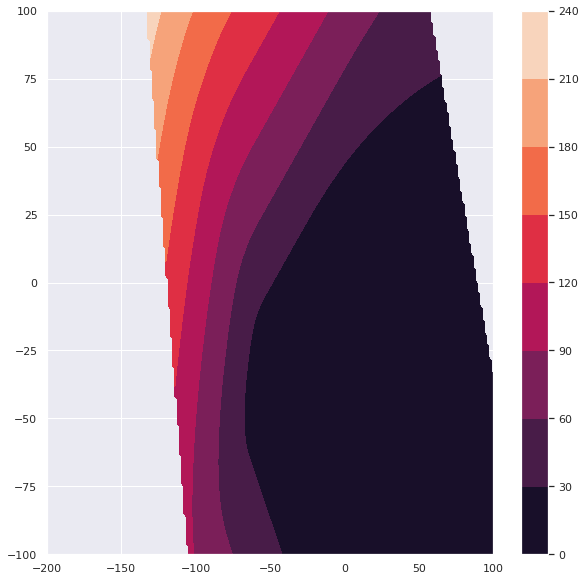

In [ ]:
X, Y = np.meshgrid(x_e, y_e)
Z = z
X.shape, Y.shape, Z.shape

fig = plt.figure(figsize=(10,10))
ax = plt.gca()
cp = ax.contourf(X, Y, Z)
# plt.scatter(-5, -49, color='white', marker='o', facecolors='none')
fig.colorbar(cp)
#plt.xlabel("Beta_offset values")
##ìplt.ylabel("Beta_1 values")
#.title("Log loss contour plot")
plt.savefig('log_error.png')


In [ ]:
y_pred = y_pred_lrp
x_lr = np.linspace(-5, 12, 100)
y_lr, y_lr_s = [], []
for x in x_lr:
  y_lr.append(w[0] + x*w[1])
  x_offset = np.insert(np.array(x), 0, 1)
  y_lr_s.append(sigmoid(x_offset, w))
ab_y = [0.5] * 100

# PLOT WITH STRAIGHT LINE
plt.figure(figsize=(10,10))
plt.scatter(X_test, y_test, color='navy', facecolors='none', label='Real labels')
plt.scatter(X_test, y_pred, color='green', marker='^', facecolors='none')
plt.plot(x_lr, y_lr_s, 'g-', label='Predicted labels')
plt.plot(x_lr, ab_y, 'r--', label='Threshold line')
plt.ylim((-0.1, 1.2))
plt.legend(loc='best')
plt.ylabel('Label')
plt.xlabel('PCA[1]')
plt.savefig('PCA_plot.png')

In [ ]:
# PLOT RESULT

result_plot(X_test, y_test, y_pred_knn)

In [ ]:
# STAT FUNCTIONS

def cf_stats_old(predictions, y_test):
  acc, tpr, tnr = [], [], []
  for k, p in predictions.items():
    tn, fp, fn, tp = confusion_matrix(p, y_test).ravel()
    print(tn, fp, fn, tp, tn/(fp+tn))
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(fp+tn))
    acc.append((tp+tn)/(tn+tp+fn+fp))
  return list(predictions.keys()), acc, tpr, tnr

def cf_stats(predictions, y_test):
  acc, tpr, tnr = [], [], []
  for k, p in predictions.items():
    d = classification_report(y_test, p, target_names=['malignant','benignant'], output_dict=True)
    tpr.append(d['benignant']['recall'])
    tnr.append(d['malignant']['recall'])
    acc.append(d['accuracy'])
  return list(predictions.keys()), acc, tpr, tnr

In [ ]:
# PLOT LOGISTIC REGRESSION

plt.figure(figsize=(10,10))
learning_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
styles = ['b-', 'r-', 'g-', 'c-', 'k-']
accuracies = dict()
for l, style in zip(learning_rates, styles):
  it_values, lr_acc, lr_tpr, lr_fpr = cf_stats(pickle.load(open("lr_results_{}.roc".format(l), "rb")), y_test)
  plt.plot(it_values[:], lr_acc[:], style, label="LR={}".format(l))

plt.yticks(np.linspace(0.4,1,7))
plt.ylabel('Accuracy')
plt.xlabel('#Iterations')
plt.legend(loc='best')
plt.savefig('learning_rate_stats.png')

In [ ]:
# PLOT KNN

k_values, acc_35, sn_35, sp_35 = cf_stats(pickle.load(open("knn_results.roc", "rb")), y_test)
k_values, acc_06, sn_06, sp_06 = cf_stats(pickle.load(open("knn_results_c06.roc", "rb")), y_test)
k_values, acc_03, sn_03, sp_03 = cf_stats(pickle.load(open("knn_results_c03.roc", "rb")), y_test)
k_values, acc_PCA, sn_PCA, sp_PCA = cf_stats(pickle.load(open("knn_results_PCA.roc", "rb")), y_test)

plt.figure(figsize=(10,10))
plt.plot(k_values, acc_35, 'b-', label="Accuracy")
plt.plot(k_values, sn_35, 'r-', label="Sensitivity")
plt.plot(k_values, sp_35, 'g-', label="Specificity")
#plt.yticks(np.linspace(0.4,1,7))
plt.xlabel('K')
plt.ylabel('Performance')
plt.legend(loc='best')
plt.title("Statistiche in funzione di K\n(tutti i predittori)")
plt.savefig('KNN_all_stats.png')

plt.figure(figsize=(10,10))
plt.plot(k_values, acc_35, 'b-', label="All predictors")
plt.plot(k_values, acc_06, 'r-', label="Corr < 0.6")
plt.plot(k_values, acc_03, 'g-', label="Corr < 0.3")
plt.plot(k_values, acc_PCA, 'k-', label="Principal component")
plt.yticks(np.linspace(0.4,1,7))
plt.legend(loc='best')
plt.title("Accuracy per le diverse scelte\ndi variabili in funzione di K")
plt.savefig('KNN_all_acc.png')


plt.figure(figsize=(10,10))
plt.plot(k_values, sn_35, 'b-', label="All predictors")
plt.plot(k_values, sn_06, 'r-', label="Corr < 0.6")
plt.plot(k_values, sn_03, 'g-', label="Corr < 0.3")
plt.plot(k_values, sn_PCA, 'k-', label="Principal component")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Sensitivity")

plt.figure(figsize=(10,10))
plt.plot(k_values, sp_35, 'b-', label="All predictors")
plt.plot(k_values, sp_06, 'r-', label="Corr < 0.6")
plt.plot(k_values, sp_03, 'g-', label="Corr < 0.3")
plt.plot(k_values, sp_PCA, 'k-', label="Principal component")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Specificity")

In [ ]:
# PLOT LOGISTIC REGRESSION

k_values, acc_35, sn_35, sp_35 = cf_stats(pickle.load(open("lr_results_0.5.roc", "rb")), y_test)
k_values, acc_06, sn_06, sp_06 = cf_stats(pickle.load(open("lr_results_c06.roc", "rb")), y_test)
k_values, acc_03, sn_03, sp_03 = cf_stats(pickle.load(open("lr_results_c03.roc", "rb")), y_test)
k_values, acc_PCA, sn_PCA, sp_PCA = cf_stats(pickle.load(open("lr_results_PCA.roc", "rb")), y_test)

plt.figure(figsize=(10,10))
plt.plot(k_values, acc_35, 'b-', label="Accuracy")
plt.plot(k_values, sn_35, 'r-', label="Sensitivity")
plt.plot(k_values, sp_35, 'g-', label="Specificity")
#plt.yticks(np.linspace(0.4,1,7))
plt.xlabel('#Iterations')
plt.ylabel('Performance')
plt.legend(loc='best')
plt.title("Statistiche in funzione del numero di iterazioni\n(tutti i predittori)")
plt.savefig('lr_all_stats.png')

plt.figure(figsize=(10,10))
plt.plot(k_values, acc_35, 'b-', label="All predictors")
plt.plot(k_values, acc_06, 'r-', label="Corr < 0.6")
plt.plot(k_values, acc_03, 'g-', label="Corr < 0.3")
plt.plot(k_values, acc_PCA, 'k-', label="Principal component")
plt.xlabel('#Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title("Accuracy in funzione del numero di iterazioni\n(tutti i predittori)")
plt.savefig('lr_all_acc.png')

plt.figure(figsize=(10,10))
plt.plot(k_values, sn_35, 'b--', label="All predictors")
plt.plot(k_values, sn_06, 'r--', label="Corr < 0.6")
plt.plot(k_values, sn_03, 'g--', label="Corr < 0.3")
plt.plot(k_values, sn_PCA, 'k--', label="Principal component")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Sensitivity")

plt.figure(figsize=(10,10))
plt.plot(k_values, sp_35, 'b--', label="All predictors")
plt.plot(k_values, sp_06, 'r--', label="Corr < 0.6")
plt.plot(k_values, sp_03, 'g--', label="Corr < 0.3")
plt.plot(k_values, sp_PCA, 'k--', label="Principal component")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Specificity")

In [ ]:
# DECISION REGION PLOT

def euclidean_distance(element):
  return ((element[:-1]-x_br.value)**2).sum()

def k_nearest(data):
  return sorted(data, key=euclidean_distance)[:k_br.value]

k = 21
b_pred = []
k_br = sc.broadcast(k)
knn_predictions = []
for x in np.linspace(-5.5, 13, 100):
  x_br = sc.broadcast(x)
  nn = k_nearest(RDD.mapPartitions(k_nearest).collect())
  knn_predictions.append([majority_voting(nn)]*30)




In [ ]:
y_pred = pickle.load(open("knn_results_PCA.roc", "rb"))[21]
plt.figure(figsize=(10,10))
plt.ylim((-0.1,1.1))
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
yy, xx = np.meshgrid(np.linspace(ylim[0], ylim[1], 30), np.linspace(-5.5, 13, 100))
ax.contourf(xx, yy, knn_predictions, 25, cmap="RdBu", alpha=0.6, levels=[0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 1], zorder=0)
# ax.contour(y_pred)

plt.scatter(X_test, y_test, color = 'black')
plt.savefig('KNN_pca_decrig.png')
